# Amazon Fine Food Reviews Analysis

Data distribution.<br>

reviews: 568,454<br>
users: 256,059<br>
products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Attributes/Columns in data: 10 

Attributes:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

<b>Objective:-</b>
determining whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored.




## Data Loading

The dataset is available in two forms
1. .csv file
2. SQLite Database

here, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
#Importing required libraries
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite')  
# not considering those reviews with Score 3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 
# reviews with Score>3 is positive, and reviews with a score<3 are negative.
def partition(x):
    if x < 3:
        return 0
    return 1
#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
sample_data = filtered_data.head(40000) #Sampling reviews filtered data to 40k datapoints for time effiecieny

# Exploratory Data Analysis

## Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [5]:
#Reading the data from SQL table
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As seen above, the same user has several reviews of HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text with the same values and found during the analysis, <br>

It has been shown that reviews of the same product flavour or quantity with identical characteristics, other than ProductId. Therefore it was agreed to remove rows with the same parameters to avoid repetition..<br>

It has been shown that reviews of the same product flavour or quantity with identical characteristics, other than ProductId. Therefore it was agreed to remove rows with the same parameters to avoid repetition.

In [6]:
#Sorting data according to ProductId in ascending order
sorted_data=sample_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [7]:
#Removing duplicate entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(37415, 10)

In [8]:
#Final verification of remained data
(final['Id'].size*1.0)/(sample_data['Id'].size*1.0)*100

93.5375

It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [10]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [11]:
#Watching number of entries left
print(final.shape)

#positive and negative reviews are present in our dataset
final['Score'].value_counts()

(37415, 10)


1    31324
0     6091
Name: Score, dtype: int64

## Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that our data have been deduplicated, some pre-processing is necessary before we continue analysing and modelling the forecast.

Hence in the Preprocessing phase we do the following in the order below:-

1. Start with html tags removal
2. Remove any special character sets or punctuations, such as, # or # etc.
3. Check whether the term is English and does not have an alpha-numeric word
4. To verify if the word length is more than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the term to a reduction
6. Delete Words Stop
7. Snowball Take the word finally (it was shown better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [12]:
# finding the sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

2
Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [13]:
# import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'doing', 'after', 'these', 'same', "needn't", 'herself', "hadn't", 'm', 'didn', 'shouldn', 'my', 'are', 'doesn', 'wouldn', "should've", 'no', 're', 'o', 'mightn', 'then', 'just', 'as', 'me', 'does', 'such', 'nor', 'her', 'itself', 'mustn', 'this', 'more', 'where', "aren't", 'you', 'll', 'all', 'that', "won't", 'd', 'than', 'been', 'don', 'between', 'own', 'aren', 'by', "you'd", 'an', 'other', "doesn't", 'yourselves', "didn't", 'being', 've', 'haven', 'if', 'i', 'again', 'when', 'hasn', 'had', 'each', 'ourselves', 'those', 'so', 'will', 'from', 'their', 'ain', 'his', 'to', 'why', "don't", 'shan', 'was', 'myself', 'until', 'because', 'for', 'or', "isn't", "shan't", 'up', 'into', 'he', 'hadn', 'of', "she's", 'them', 'there', 'yourself', 'what', 't', 'were', 'having', 'we', "weren't", 'against', 'wasn', 'yours', 'not', 'only', 'your', 'should', "haven't", 'hers', "mustn't", 'themselves', 'our', "wouldn't", 'which', 'the', 'how', 'is', "shouldn't", "mightn't", 'before', 'in', 'few', 'a', '

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
if not os.path.isfile('final.sqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(final['Text'].values)):
        filtered_sentence=[]
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8') #snoball stemmer
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
    conn = sqlite3.connect('final.sqlite')   # storing final table into an SQlLite table for future.
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    with open('positive_words.pkl', 'wb') as f: # 'wb' instead 'w' for binary file
        pickle.dump(all_positive_words, f)      # dumping data to f
    with open('negitive_words.pkl', 'wb') as f: 
        pickle.dump(all_negative_words, f)      

In [15]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please check the above cell")

### Sorting dataset based on 'Time'

In [16]:
final_reviews = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final_reviews.shape

(46071, 12)

### Spliting data for train and test

In [17]:
#split data into train, cross validate and test 
%matplotlib inline
import warnings
from sklearn.model_selection import train_test_split
X = final_reviews['CleanedText'] # X contains comments
Y = final_reviews['Score'] # Y contains score
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.33, random_state=0) # splitting data into train and test
X_tr, X_cv, Y_tr, Y_cv = train_test_split(X_train, Y_train, test_size=.33, random_state=0) # splitting data intotrain and cross validation

In [18]:
print('X_train, Y_train', X_train.shape, Y_train.shape)
print('X_test, Y_test', X_test.shape, Y_test.shape)
print('X_tr, Y_tr', X_tr.shape, Y_tr.shape)
print('X_cv, Y_cv', X_cv.shape, Y_cv.shape)

X_train, Y_train (30867,) (30867,)
X_test, Y_test (15204,) (15204,)
X_tr, Y_tr (20680,) (20680,)
X_cv, Y_cv (10187,) (10187,)


# K-NN using Brute Force with simple CV

In [19]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import f1_score

## Training Model with Brute Force and KD-Tree

In [20]:
#find knn to simple cross validation with Brute Force and KD-Tree
from sklearn.metrics import roc_auc_score
def KNN(X_train,X_cv,Y_train,Y_cv):
    k = []
    max_k = 0
    pred_cv = []
    pred_train = []
    max_roc_auc=-1
    for i in range(1,24,2):
        knn =KNeighborsClassifier(n_neighbors=i,algorithm='brute')
        knn.fit(X_train,Y_train)
        probs = knn.predict_proba(X_cv)
        prob = knn.predict_proba(X_train)
        # keep probabilities for the positive outcome only
        probs = probs[:, 1]
        prob  = prob[:, 1]
        auc_score_test = roc_auc_score(Y_cv,probs)   #find AUC score
        auc_score_train = roc_auc_score(Y_train,prob)
        print(i," ------> ",auc_score_test)
        pred_cv.append(auc_score_test)
        pred_train.append(auc_score_train)
        k.append(i)
        if(max_roc_auc<auc_score_test):
            max_roc_auc=auc_score_test
            max_k=i
    #print('\nThe optimal number of neighbors is %d.' % max_k)
    plt.plot(k, pred_cv,'r-', label = 'CV Data')
    plt.plot(k,pred_train,'g-', label ='Train Data')
    plt.legend(loc='upper right')
    plt.title("K v/s Auc Score")
    plt.ylabel('Auc Score')
    plt.xlabel('K')
    plt.show()
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(Y_cv,probs)
    # plot no skill
    pyplt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    pyplt.plot(fpr, tpr, marker='.')
    #plt.plot(k,pred_cv)
    pyplt.title("Line Plot of ROC Curve")
    pyplt.ylabel('True Positive Rate')
    pyplt.xlabel('False Positive Rate')
    pyplt.show()

## Testing Model with Brute Force and KD-Tree

In [22]:
import scikitplot.metrics as skplt
def testing(X_train,Y_train,X_test,Y_test,algo,optimal_k):
    if algo == 'brute':
        knn =KNeighborsClassifier(n_neighbors=optimal_k,algorithm='brute') 
    else:
        knn =KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
    knn.fit(X_train,Y_train)
    probs = knn.predict_proba(X_test) 
    probs = probs[:, 1] # keeping the probability only for the positive response
    print("AUC Score",roc_auc_score(Y_test,probs))
    fpr, tpr, thresholds = roc_curve(Y_test,probs)  # calculating ROC curve
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')# plotting the roc curve for the model
    plt.show
    prediction=knn.predict(X_test) # predicting the outcome using test dataset
    # confusion matrix
    skplt.plot_confusion_matrix(Y_test,prediction)
    print("macro f1 score for data :",metrics.f1_score(Y_test, prediction, average = 'macro'))
    print("micro f1 scoore for data:",metrics.f1_score(Y_test, prediction, average = 'micro'))
    print("hamming loss for data:",metrics.hamming_loss(Y_test,prediction))
    print("Precision recall report for data:\n",metrics.classification_report(Y_test, prediction))        

# Vectorization

##  Bag of Words (BoW) 

In [23]:
count_vect = CountVectorizer() #in scikit-learn
bow_train = count_vect.fit_transform(X_tr)
print("The type of count vectorizer ",type(bow_train))
print("The shape of out text BOW vectorizer ",bow_train.get_shape())
bow_cv = count_vect.transform(X_cv)
bow_test = count_vect.transform(X_test)
print("CV Data Size: ",bow_cv.shape)
print("Test Data Size: ",bow_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text BOW vectorizer  (20680, 17391)
CV Data Size:  (10187, 17391)
Test Data Size:  (15204, 17391)


In [24]:
# Normalizing the data
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
bow_train=preprocessing.normalize(bow_train) # Normalizing the train data
bow_cv=preprocessing.normalize(bow_cv) # Normalizing the validation data
bow_test=preprocessing.normalize(bow_test) #Normalizing the test data
print("The shape of out text BOW vectorizer ",bow_train.get_shape())
print("CV Data Size: ",bow_cv.shape)
print("Test Data Size: ",bow_test.shape)

The shape of out text BOW vectorizer  (20680, 17391)
CV Data Size:  (10187, 17391)
Test Data Size:  (15204, 17391)


1  ------>  0.6358434837927727
3  ------>  0.7249810082773754
5  ------>  0.7519663792657778
7  ------>  0.772804535323886
9  ------>  0.7903691502622223
11  ------>  0.7975748036923642
13  ------>  0.8056290891440586
15  ------>  0.8134675008185468
17  ------>  0.8175302216107854
19  ------>  0.8230820514219739
21  ------>  0.8256346969079034
23  ------>  0.8293785793473454


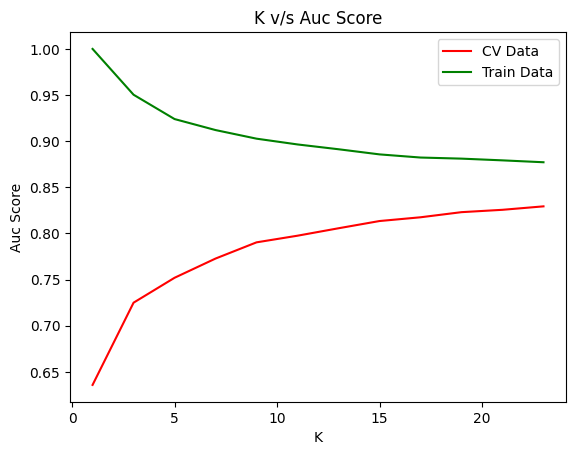

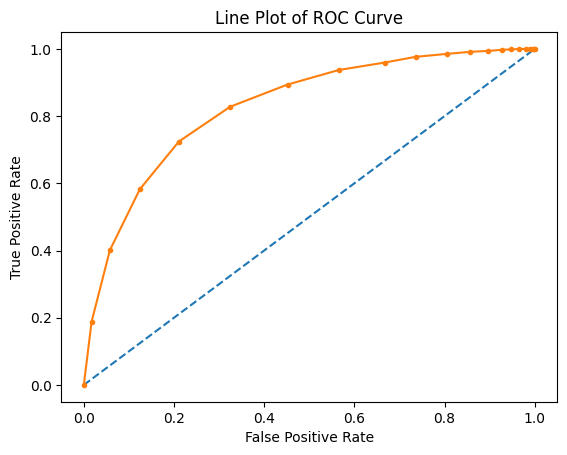

In [25]:
# finding the optimal k using brute force
KNN(bow_train,bow_cv,Y_tr,Y_cv)

### KNN with simple CV Over the unseen or Test data in BoW

AUC Score 0.7783899941007902
macro f1 score for data : 0.5862673994167019
micro f1 scoore for data: 0.8470139436990266
hamming loss for data: 0.15298605630097342
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.66      0.16      0.26      2526
           1       0.85      0.98      0.91     12678

    accuracy                           0.85     15204
   macro avg       0.76      0.57      0.59     15204
weighted avg       0.82      0.85      0.81     15204



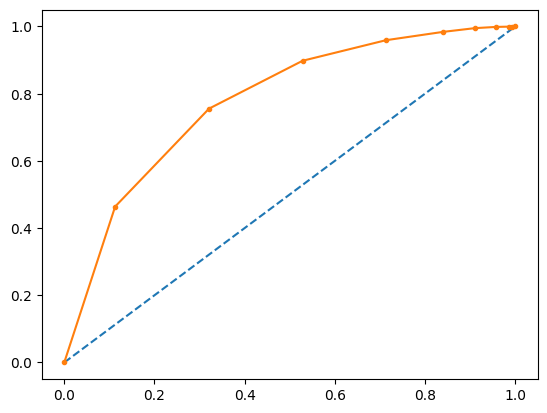

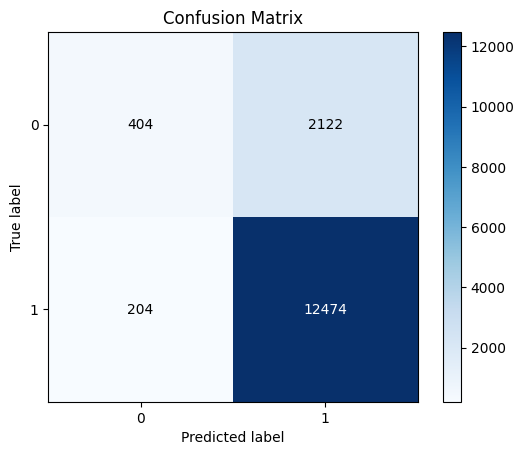

In [26]:
#algorithm = brute force, optimal_k=11 (because, at k=11, the curve doesn't change much)
testing(bow_train,Y_tr,bow_test,Y_test,'brute',optimal_k=9)

##  TF-IDF Vectorization (Included with Normalization)

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2)) # Initializing TF-IDF Vectorizer for bigrams
tfidf_train = tf_idf_vect.fit_transform(X_tr)
print("The type of count vectorizer ",type(tfidf_train))
print("The shape of out text TFIDF vectorizer ",tfidf_train.get_shape()) #
tfidf_cv = tf_idf_vect.transform(X_cv)
tfidf_test = tf_idf_vect.transform(X_test)
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text TFIDF vectorizer  (20680, 397694)
CV Data Size:  (10187, 397694)
Test Data Size:  (15204, 397694)


In [28]:
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
tfidf_train=preprocessing.normalize(tfidf_train)
tfidf_cv=preprocessing.normalize(tfidf_cv) 
tfidf_test=preprocessing.normalize(tfidf_test)
print("The shape of out text BOW vectorizer ",tfidf_train.get_shape())
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The shape of out text BOW vectorizer  (20680, 397694)
CV Data Size:  (10187, 397694)
Test Data Size:  (15204, 397694)


1  ------>  0.6144461669031358
3  ------>  0.7155889372677193
5  ------>  0.7479457346529649
7  ------>  0.7738336066609608
9  ------>  0.7833393048957717
11  ------>  0.7951199530125395
13  ------>  0.8034872967275358
15  ------>  0.8133459035321013
17  ------>  0.8178875460253088
19  ------>  0.8234124858549363
21  ------>  0.8294945042478272
23  ------>  0.8345708588710373


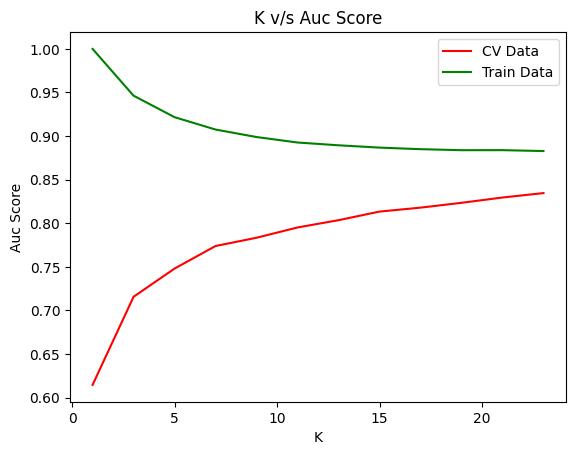

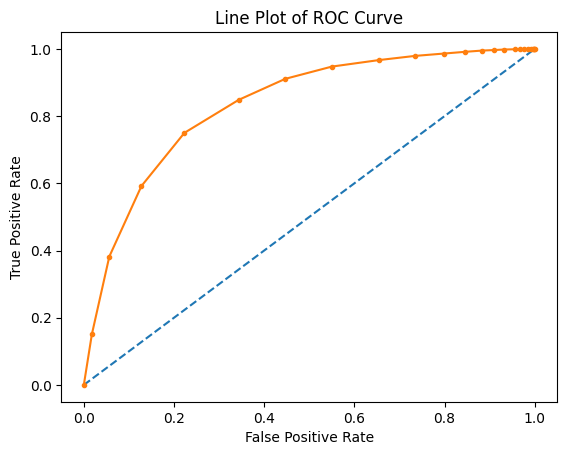

In [29]:
# plotting graph for K values vs AUC Score
KNN(tfidf_train,tfidf_cv,Y_tr,Y_cv)

### KNN with simple Cross Validation on Test data in TF-IDF

AUC Score 0.7833233847400195
macro f1 score for data : 0.5953638628151352
micro f1 scoore for data: 0.851223362273086
hamming loss for data: 0.14877663772691396
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.72      0.17      0.27      2526
           1       0.86      0.99      0.92     12678

    accuracy                           0.85     15204
   macro avg       0.79      0.58      0.60     15204
weighted avg       0.83      0.85      0.81     15204



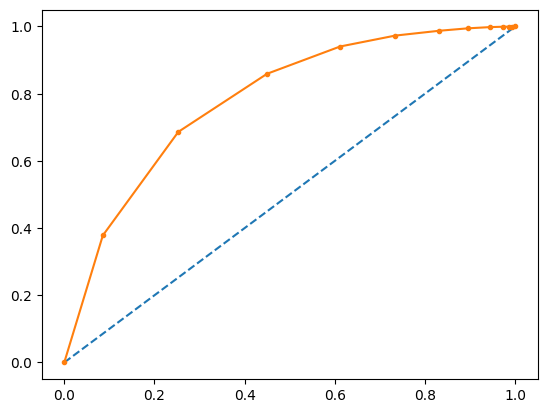

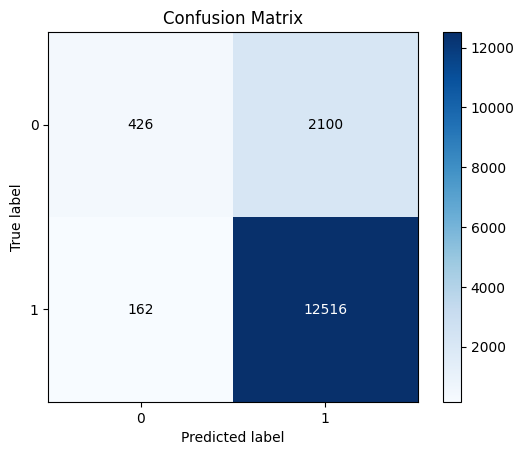

In [30]:
##brute force algo for optimal_k=11 (at k=11, curve dosent changes much)
testing(tfidf_train,Y_tr,tfidf_test,Y_test,'brute',optimal_k=11)

## KNN using Average Word to Vector

In [31]:
# Now,we create and train word-to-vector model on our review set
import gensim
i=0
list_of_sent=[]
for sent in final_reviews['CleanedText'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [32]:
# we are considering the words which occured atleast 5 times, rest of words are of no use
#size is dimentionality of vector corpus
# workers defines no of cores
w2v_model=Word2Vec(list_of_sent,min_count=5,vector_size=50, workers=4)

In [33]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # for each review,[(W2V(w1)+W2V(w2)+W2V(w3)+....)/n] is stored
for sent in list_of_sent: # iterating through each review
    sent_vec = np.zeros(50) # as word vectors are of zero length intially and we took 50 as dimension factor before
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence..['dog','eats','food']
        try:
            vec = w2v_model.wv[word]# converting each word in reviews as vector
            sent_vec += vec #adding all values of vectorized words in a document in this numpy array
            cnt_words += 1  # counting no.of words as we need average valued vector
        except:
            pass
    sent_vec /= cnt_words # averaging all values
    sent_vectors.append(sent_vec)   # appending these vectors into our list 

In [34]:
# split data into Train, CV and Test datasets
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(sent_vectors,Y, test_size=.33, random_state=0)
X_tr1, X_cv1, Y_tr1, Y_cv1 = train_test_split(X_train1, Y_train1, test_size=.33, random_state=0)
# X_tr1 = np.nan_to_num(X_tr1)
# X_tr1=np.array(X_tr1)
# X_tr1=pd.DataFrame(X_tr1).fillna(0)
# X_cv1=np.array(X_cv1)
# X_cv1=pd.DataFrame(X_cv1).fillna(0)
# X_test1=np.array(X_test1)
# X_test1=pd.DataFrame(X_test1).fillna(0)
# X_cv1 = np.nan_to_num(X_cv1)
# X_test1 = np.nan_to_num(X_test1)
train_avgw2v=preprocessing.normalize(X_tr1)
cv_avgw2v=preprocessing.normalize(X_cv1)
test_avgw2v=preprocessing.normalize(X_test1)
print(train_avgw2v.shape)
print(cv_avgw2v.shape)
print(test_avgw2v.shape)
#print(len(X_train1))

(20680, 50)
(10187, 50)
(15204, 50)


1  ------>  0.7006509960422542
3  ------>  0.8007690391121783
5  ------>  0.8336092458455159
7  ------>  0.8522332686154783
9  ------>  0.8635180855769176
11  ------>  0.8707079065880097
13  ------>  0.8752416508222807
15  ------>  0.8795680298582909
17  ------>  0.8839967272487061
19  ------>  0.8844654171142347
21  ------>  0.8846969797057826
23  ------>  0.8859554954649633


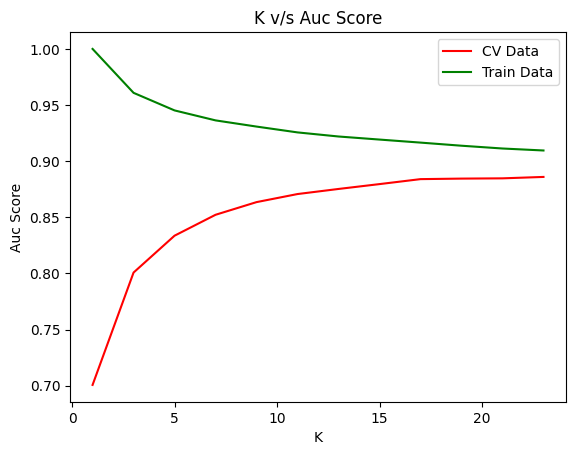

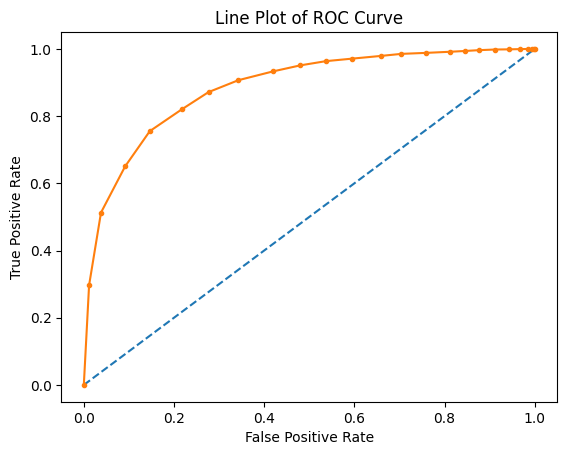

In [35]:
# finding the optimal k using brute force method
KNN(train_avgw2v,cv_avgw2v,Y_tr1,Y_cv1)

### KNN with simple CV Over the unseen or Test data in AvgW2V

AUC Score 0.8390244220791574
macro f1 score for data : 0.6999860677293347
micro f1 scoore for data: 0.8652986056300973
hamming loss for data: 0.13470139436990267
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.67      0.37      0.48      2526
           1       0.88      0.96      0.92     12678

    accuracy                           0.87     15204
   macro avg       0.78      0.67      0.70     15204
weighted avg       0.85      0.87      0.85     15204



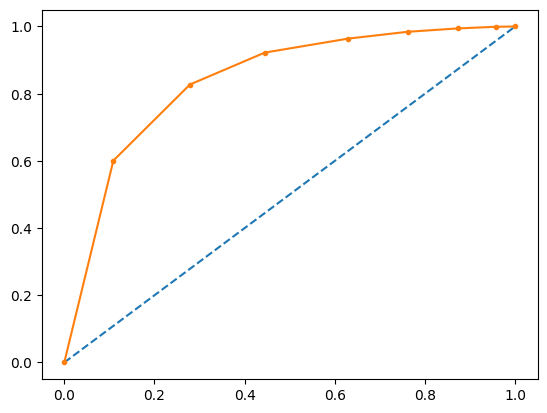

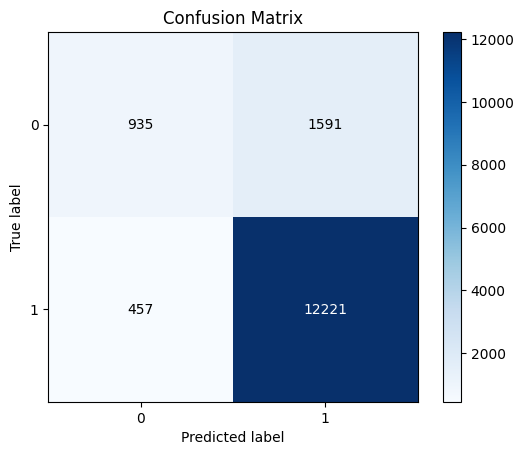

In [36]:
#brute force algo with  optimal_k=7
testing(train_avgw2v,Y_tr1,test_avgw2v,Y_test1,'brute',optimal_k=7)

## Modelling using TF-IDF Weighted Word2Vec

In [37]:
#tf-idf weighted w2v

from sklearn.feature_extraction.text import TfidfVectorizer
tfidfw2v_vect = TfidfVectorizer()
tfidfw2v= tfidfw2v_vect.fit_transform(final_reviews['CleanedText'].values) 
print(type(tfidfw2v))
print(tfidfw2v.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(46071, 24780)


In [38]:
# TF-IDF weighted Word2Vec
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
t=tfidfw2v_vect.get_feature_names()
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent:
    sent_vec = np.zeros(50)
    cnt_words = 0;
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tfidfw2v[row,t.index(word)]
            sent_vec += (vec*tfidf)
            cnt_words += tfidf
        except:
            pass
    sent_vec /= cnt_words
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [39]:
#splitting dataset as train, test, validation datasets dataset
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(tfidf_sent_vectors, final['Score'], test_size=0.33,random_state=0)
X_tr2, X_cv2, Y_tr2, Y_cv2 = train_test_split(X_train2, Y_train2, test_size=.33, random_state=0)
# X_tr2 = np.nan_to_num(X_tr2)
# X_cv2 = np.nan_to_num(X_cv2)
# X_test2 = np.nan_to_num(X_test2)
train_tfidfw2v=preprocessing.normalize(X_tr2)
cv_tfidfw2v=preprocessing.normalize(X_cv2)
test_tfidfw2v=preprocessing.normalize(X_test2)
print(train_tfidfw2v.shape)
print(cv_tfidfw2v.shape)
print(test_tfidfw2v.shape)

(20680, 50)
(10187, 50)
(15204, 50)


1  ------>  0.49557631394728274
3  ------>  0.4896839456885617
5  ------>  0.4901029255816855
7  ------>  0.48588973447279227
9  ------>  0.4845633113620138
11  ------>  0.4861540834078417
13  ------>  0.4862952335405707
15  ------>  0.48564666375564014
17  ------>  0.48485621608134244
19  ------>  0.48225351575766395
21  ------>  0.4793950263032042
23  ------>  0.47649720333520473


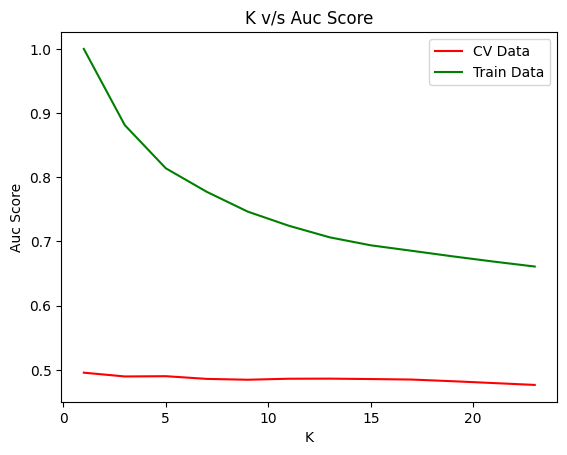

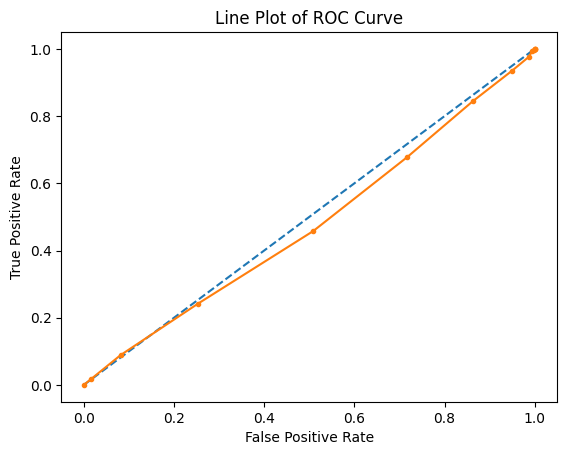

In [40]:
# finding the optimal k using brute force
KNN(train_tfidfw2v,cv_tfidfw2v,Y_tr2,Y_cv2)

Observation : This model is very close to a random model (AUC=0.5) and cannot be optimal compared to previous models

### KNN with CV Over the  Test data using TF-IDF W2V

AUC Score 0.503813149167851
macro f1 score for data : 0.5037214227461952
micro f1 scoore for data: 0.7253354380426204
hamming loss for data: 0.27466456195737965
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.17      0.18      0.17      2475
           1       0.84      0.83      0.84     12729

    accuracy                           0.73     15204
   macro avg       0.50      0.50      0.50     15204
weighted avg       0.73      0.73      0.73     15204



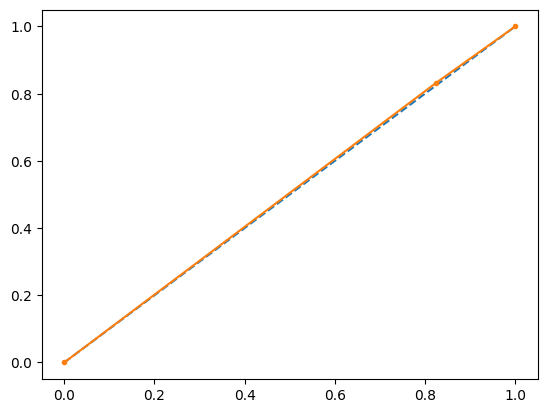

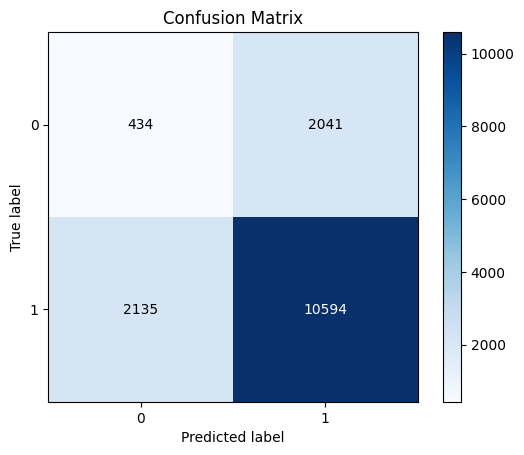

In [41]:
#brute force algo with optimal_k= 1
testing(train_tfidfw2v,Y_tr2,test_tfidfw2v,Y_test2,'brute',optimal_k=1)

here the model is close to random model (AUC=0.5) and a bad predictor where false positives are much higher in number

# K-NN with KD-Tree 

In [42]:
#find knn to simple cross validation with KD-Tree
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import roc_auc_score
def KNN_kdtree(X_train,X_cv,Y_train,Y_cv,n_components):
    k = []
    max_k = 0
    pred_cv = []
    pred_train = []
    max_roc_auc=-1
    svd = TruncatedSVD(n_components=n_components)
    X_train = svd.fit_transform(X_train)
    X_cv = svd.fit_transform(X_cv)
    for i in range(1,24,2):
        knn =KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
        knn.fit(X_train,Y_train)
        probs = knn.predict_proba(X_cv)
        prob = knn.predict_proba(X_train)
        # keep probabilities for the positive outcome only
        probs = probs[:, 1]
        prob = prob[:,1]
        auc_score_test = roc_auc_score(Y_cv,probs) #find AUC score
        auc_score_train = roc_auc_score(Y_train,prob)
        print(i," ------> ",auc_score_test)
        pred_cv.append(auc_score_test)
        pred_train.append(auc_score_train)
        k.append(i)
        if(max_roc_auc<auc_score_test):
            max_roc_auc=auc_score_test
            max_k=i
    #print('\nThe optimal number of neighbors is %d.' % max_k)
    plt.plot(k, pred_cv,'r-', label = 'CV Data')
    plt.plot(k,pred_train,'g-', label ='Train Data')
    plt.legend(loc='upper right')
    plt.title("K v/s Auc Score")
    plt.ylabel('Auc Score')
    plt.xlabel('K')
    plt.show()
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(Y_cv,probs)
    # plot no skill
    pyplt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    pyplt.plot(fpr, tpr, marker='.')
    #plt.plot(k,pred_cv)
    pyplt.title("Line Plot of ROC Curve")
    pyplt.ylabel('True Positive Rate')
    pyplt.xlabel('False Positive Rate')
    pyplt.show()

In [43]:
# considering 30k data points as kd tree takes much more time for computation
final_review = final_reviews.head(30000) #Sampled amazon fine foood reviews final revievs data to 30k datapoints for time effiecieny
final_review.shape

(30000, 12)

## Spliting dataset  as train, test and cross validation

In [44]:
#split data into train, cross validate and test 
%matplotlib inline
import warnings
from sklearn.model_selection import train_test_split
X = final_review['CleanedText']
Y = final_review['Score']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.33, random_state=0)
X_tr, X_cv, Y_tr, Y_cv = train_test_split(X_train, Y_train, test_size=.33, random_state=0)

In [45]:
print('X_train, Y_train', X_train.shape, Y_train.shape)
print('X_test, Y_test', X_test.shape, Y_test.shape)
print('X_tr, Y_tr', X_tr.shape, Y_tr.shape)
print('X_cv, Y_cv', X_cv.shape, Y_cv.shape)

X_train, Y_train (20100,) (20100,)
X_test, Y_test (9900,) (9900,)
X_tr, Y_tr (13467,) (13467,)
X_cv, Y_cv (6633,) (6633,)


# Techniques for vectorization using Bag of Words

In [46]:
#BoW
count_vect = CountVectorizer() 
bow_train = count_vect.fit_transform(X_tr)
print("The type of count vectorizer ",type(bow_train))
print("The shape of out text BOW vectorizer ",bow_train.get_shape())
bow_cv = count_vect.transform(X_cv)
bow_test = count_vect.transform(X_test)
print("CV Data Size: ",bow_cv.shape)
print("Test Data Size: ",bow_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text BOW vectorizer  (13467, 14215)
CV Data Size:  (6633, 14215)
Test Data Size:  (9900, 14215)


In [47]:
# Normalization of data
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
bow_train=preprocessing.normalize(bow_train)
bow_cv=preprocessing.normalize(bow_cv)
bow_test=preprocessing.normalize(bow_test)
print("The shape of out text BOW vectorizer ",bow_train.get_shape())
print("CV Data Size: ",bow_cv.shape)
print("Test Data Size: ",bow_test.shape)

The shape of out text BOW vectorizer  (13467, 14215)
CV Data Size:  (6633, 14215)
Test Data Size:  (9900, 14215)


Text(0, 0.5, 'Cumulative explained variance')

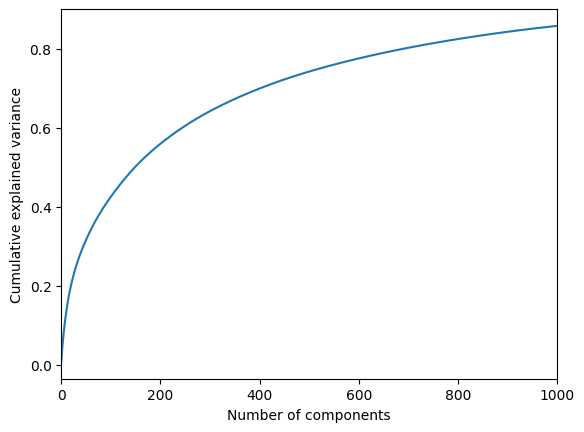

In [48]:
# explain variance of training data
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=1000).fit(bow_train)
plt.plot(np.cumsum(tsvd.explained_variance_ratio_))
plt.xlim(0,1000,10)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

From the above observation, the variance can be well explained if the number of components are 1000

1  ------>  0.49967162017644723
3  ------>  0.4978475908528876
5  ------>  0.4991213943418102
7  ------>  0.5082250069119137
9  ------>  0.5176073971624847
11  ------>  0.5239337158550609
13  ------>  0.523467438664649
15  ------>  0.5353803904830704
17  ------>  0.5469855021969829
19  ------>  0.5507120549571292
21  ------>  0.5541548016408594
23  ------>  0.5622168544332213


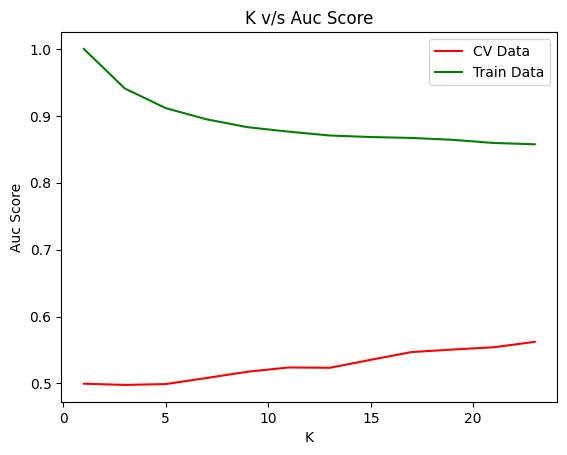

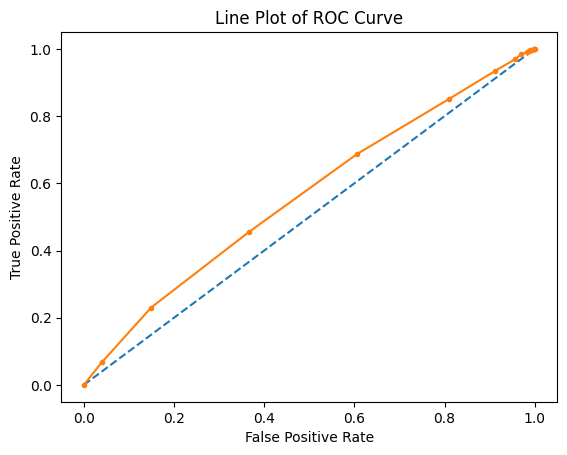

In [49]:
# Finding the optimal K using KD Tree algorithm
KNN_kdtree(bow_train,bow_cv,Y_tr,Y_cv,n_components=1000)

### KNN with simple CV Over the unseen or Test data in BoW

AUC Score 0.796098497993102
macro f1 score for data : 0.5624376964956675
micro f1 scoore for data: 0.8658585858585859
hamming loss for data: 0.13414141414141414
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.73      0.11      0.20      1432
           1       0.87      0.99      0.93      8468

    accuracy                           0.87      9900
   macro avg       0.80      0.55      0.56      9900
weighted avg       0.85      0.87      0.82      9900



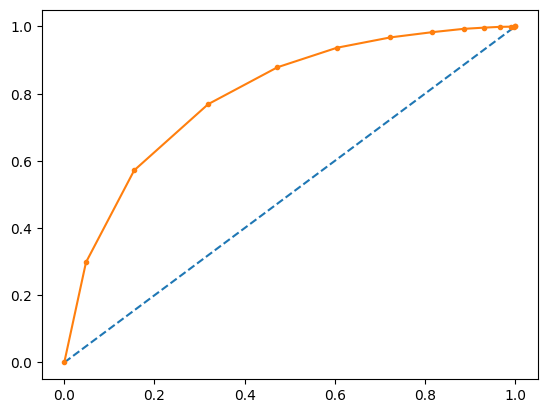

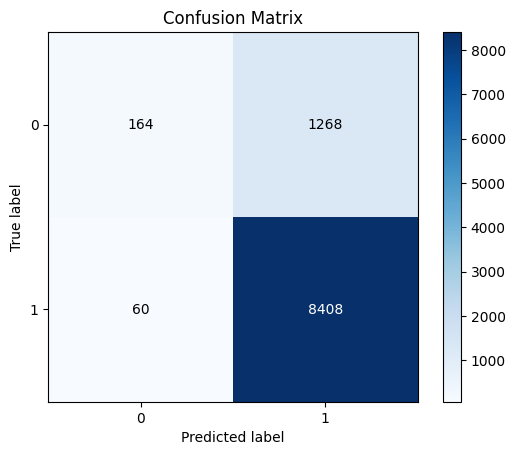

In [50]:
#algorithm = KD tree, optimal_k=9
testing(bow_train,Y_tr,bow_test,Y_test,'kd_tree',optimal_k=15)

Observation : for Bag of words using KD Tree, the AUC score is 0.79 which can be interpreted as a good model

## TF-IDF vectorization

In [51]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2)) # creating TF-IDF object
tfidf_train = tf_idf_vect.fit_transform(X_tr) 
print("The type of count vectorizer ",type(tfidf_train))
print("The shape of out text TFIDF vectorizer ",tfidf_train.get_shape())
tfidf_cv = tf_idf_vect.transform(X_cv)
tfidf_test = tf_idf_vect.transform(X_test)
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text TFIDF vectorizer  (13467, 286236)
CV Data Size:  (6633, 286236)
Test Data Size:  (9900, 286236)


In [52]:
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
tfidf_train=preprocessing.normalize(tfidf_train)
tfidf_cv=preprocessing.normalize(tfidf_cv)
tfidf_test=preprocessing.normalize(tfidf_test)
print("The shape of out text BOW vectorizer ",tfidf_train.get_shape())
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The shape of out text BOW vectorizer  (13467, 286236)
CV Data Size:  (6633, 286236)
Test Data Size:  (9900, 286236)


Text(0, 0.5, 'Cumulative explained variance')

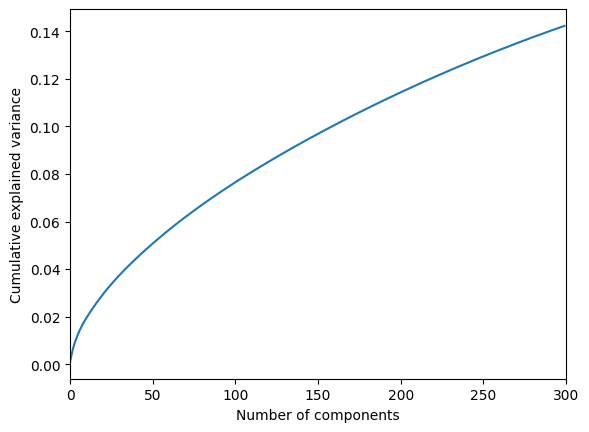

In [53]:
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=300).fit(tfidf_train)
plt.plot(np.cumsum(tsvd.explained_variance_ratio_))
plt.xlim(0,300,10)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

1  ------>  0.5063126823645802
3  ------>  0.5175565166136498
5  ------>  0.5318457690394673
7  ------>  0.5337310766119587
9  ------>  0.5352989986503444
11  ------>  0.5460201354019187
13  ------>  0.5469321500636988
15  ------>  0.5498827957608748
17  ------>  0.5501509200600952
19  ------>  0.5540802279721315
21  ------>  0.5587220340219566
23  ------>  0.5647520182617705


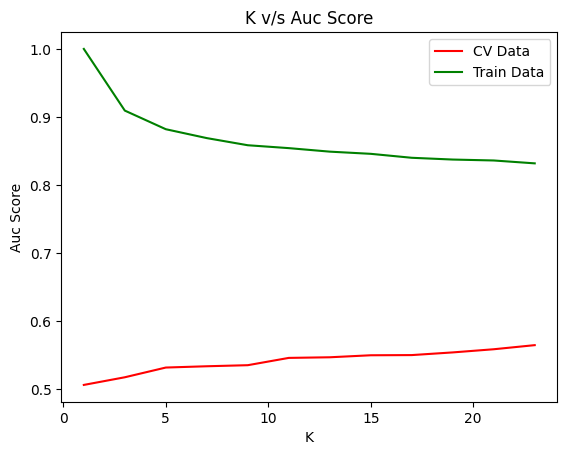

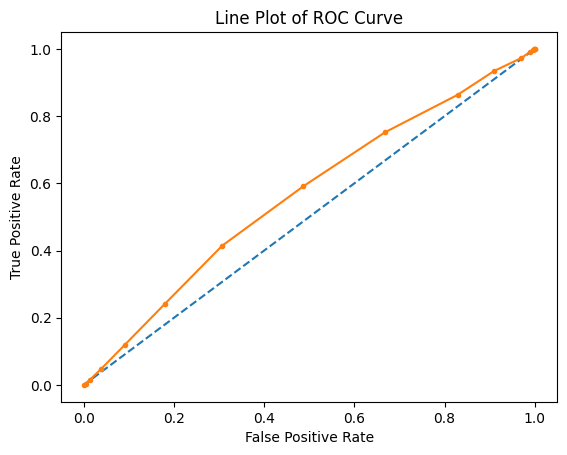

In [54]:
# finding the optimal K value
KNN_kdtree(tfidf_train,tfidf_cv,Y_tr,Y_cv,n_components=300)

### KNN with simple CV Over the unseen or Test data in TF-IDF

AUC Score 0.7607538435859746
macro f1 score for data : 0.6075077811021925
micro f1 scoore for data: 0.8665656565656565
hamming loss for data: 0.13343434343434343
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.63      0.19      0.29      1432
           1       0.88      0.98      0.93      8468

    accuracy                           0.87      9900
   macro avg       0.75      0.58      0.61      9900
weighted avg       0.84      0.87      0.83      9900



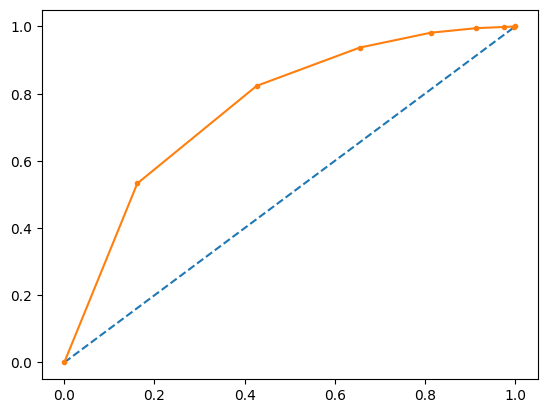

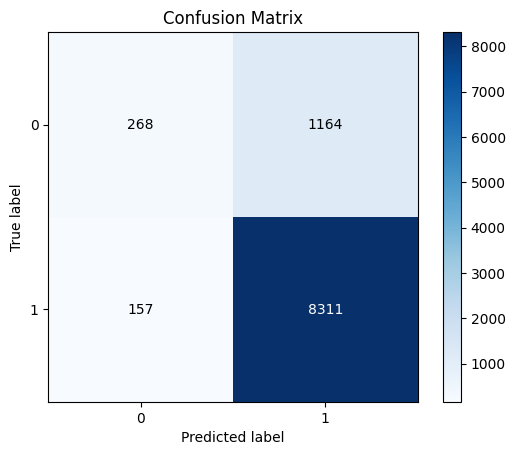

In [55]:
#algorithm = KD Tree, optimal_k=11
testing(bow_train,Y_tr,bow_test,Y_test,'kd_tree',optimal_k=7)

observation : for TF-IDF, the AUC-Score comes out to be 0.76 , which is not much good as bag-of-words model

## KD Tree using Avg W2V 

In [56]:
# Now,we create and train word-to-vector model on our review set
import gensim
i=0
list_of_sent=[]
for sent in final_review['CleanedText'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [58]:
# we are considering the words which occured atleast 5 times, rest of words are of no use
#size is dimentionality of vector corpus
# workers defines no of cores
w2v_model=Word2Vec(list_of_sent,min_count=5,vector_size=50, workers=4)

In [59]:
# computing the avg W2V
sent_vectors = []; # for each review,[(W2V(w1)+W2V(w2)+W2V(w3)+....)/n] is stored
for sent in list_of_sent: # iterating through each review
    sent_vec = np.zeros(50) # as word vectors are of zero length intially and we took 50 as dimension factor before
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence..['dog','eats','food']
        try:
            vec = w2v_model.wv[word]# converting each word in reviews as vector 
            sent_vec += vec#adding all values of vectorized words in a document in this numpy array  
            cnt_words += 1 # counting no.of words as we need average valued vector
        except:
            pass
    sent_vec /= cnt_words # averaging all values
    sent_vectors.append(sent_vec)    # appending these vectors into our list

In [60]:
# splitting our data into Train, CV and Test
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(sent_vectors,Y, test_size=.33, random_state=0)
X_tr1, X_cv1, Y_tr1, Y_cv1 = train_test_split(X_train1, Y_train1, test_size=.33, random_state=0)
train_avgw2v=preprocessing.normalize(X_tr1)
cv_avgw2v=preprocessing.normalize(X_cv1)
test_avgw2v=preprocessing.normalize(X_test1)
print(train_avgw2v.shape)
print(cv_avgw2v.shape)
print(test_avgw2v.shape)

(13467, 50)
(6633, 50)
(9900, 50)


Text(0, 0.5, 'Cumulative explained variance')

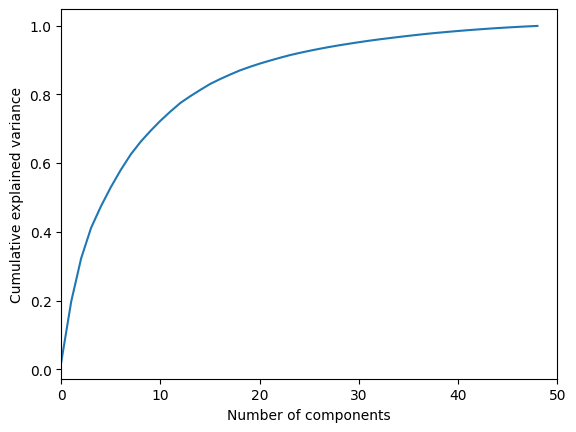

In [61]:
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=49).fit(train_avgw2v)
plt.plot(np.cumsum(tsvd.explained_variance_ratio_))
plt.xlim(0,50,10)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

here, variance can be explained better if 50 components are used

1  ------>  0.5044550735833304
3  ------>  0.5096146339617522
5  ------>  0.5123780358301335
7  ------>  0.512532041109438
9  ------>  0.5188663711447119
11  ------>  0.5214125292627075
13  ------>  0.525310899755603
15  ------>  0.5267785947832182
17  ------>  0.5280562334893897
19  ------>  0.5294698945673211
21  ------>  0.5306299199445275
23  ------>  0.5334586909602396


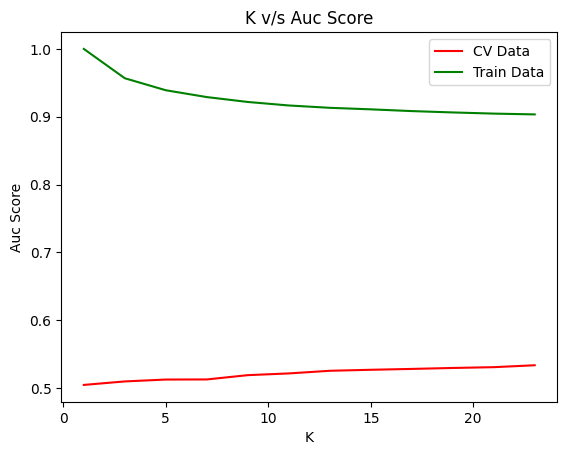

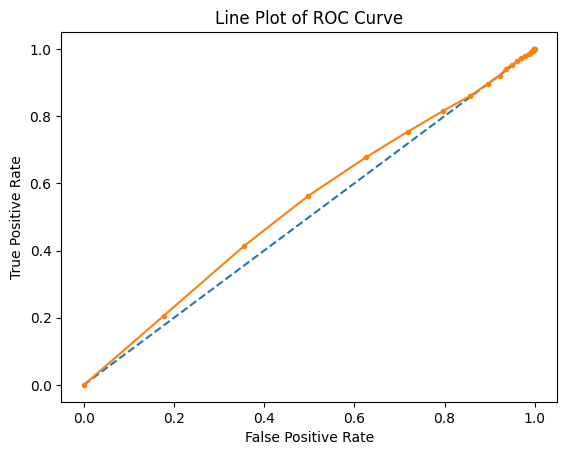

In [62]:
# finding optimal K using KD Tree
KNN_kdtree(train_avgw2v,cv_avgw2v,Y_tr1,Y_cv1,n_components=49)

### KD TreeOver the Test data in AvgW2V

AUC Score 0.8380928991959213
macro f1 score for data : 0.681714166840025
micro f1 scoore for data: 0.8797979797979798
hamming loss for data: 0.1202020202020202
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.68      0.31      0.43      1432
           1       0.89      0.98      0.93      8468

    accuracy                           0.88      9900
   macro avg       0.79      0.64      0.68      9900
weighted avg       0.86      0.88      0.86      9900



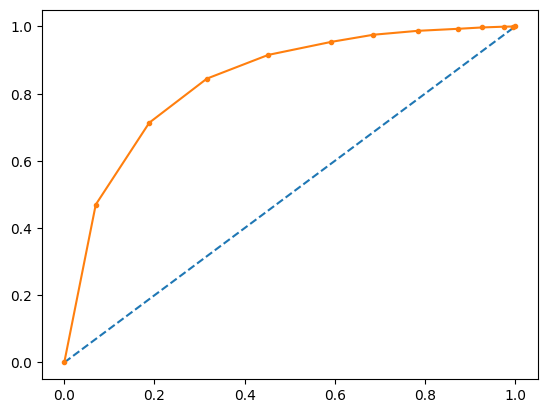

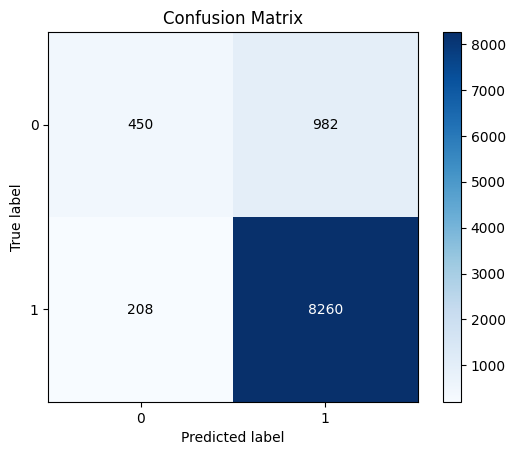

In [63]:
#KD Tree algorithm with optimal_k=7
testing(train_avgw2v,Y_tr1,test_avgw2v,Y_test1,'brute',optimal_k=11)

using avg w2vec in kd-tree , the AUC Score improved much better (0.83)

## KD Tree using TF-IDF Weighted Word2Vec

In [64]:
#Initializing the required libraries
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfw2v_vect = TfidfVectorizer()
tfidfw2v= tfidfw2v_vect.fit_transform(final_review['CleanedText'].values) 
print(type(tfidfw2v))
print(tfidfw2v.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(30000, 20418)


In [65]:
# final_tf_idf is the sparse matrix with sentence as row,column value as word and cell value = tfidf
t=tfidfw2v_vect.get_feature_names()
# the tfidf-w2v for each sentence/review is stored in this list
tfidf_sent_vectors = []; 
row=0;
for sent in list_of_sent:
    sent_vec = np.zeros(50)
    cnt_words = 0;
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tfidfw2v[row,t.index(word)]
            sent_vec += (vec*tfidf)
            cnt_words += tfidf
        except:
            pass
    sent_vec /= cnt_words
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [66]:
#splitting dataset as train, test and CV
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(tfidf_sent_vectors, final_review['Score'], test_size=0.33,random_state=0)
X_tr2, X_cv2, Y_tr2, Y_cv2 = train_test_split(X_train2, Y_train2, test_size=.33, random_state=0)
train_tfidfw2v=preprocessing.normalize(X_tr2)
cv_tfidfw2v=preprocessing.normalize(X_cv2)
test_tfidfw2v=preprocessing.normalize(X_test2)
print(train_tfidfw2v.shape)
print(cv_tfidfw2v.shape)
print(test_tfidfw2v.shape)

(13467, 50)
(6633, 50)
(9900, 50)


Text(0, 0.5, 'Cumulative wexplained variance')

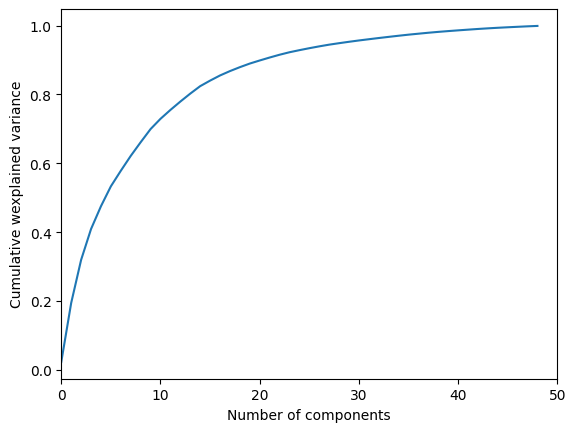

In [67]:
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=49).fit(train_tfidfw2v)
plt.plot(np.cumsum(tsvd.explained_variance_ratio_))
plt.xlim(0,50,10)
plt.xlabel('Number of components')
plt.ylabel('Cumulative wexplained variance')

Explained variance is well in the case of 50 components

1  ------>  0.5912263524765787
3  ------>  0.6773483717031193
5  ------>  0.7039764555160823
7  ------>  0.7190327513916726
9  ------>  0.7295547977545057
11  ------>  0.7361191555976616
13  ------>  0.7435962951460469
15  ------>  0.7494402287357658
17  ------>  0.7519995970465078
19  ------>  0.7553246451742228
21  ------>  0.7583845519494666
23  ------>  0.7617461624816207


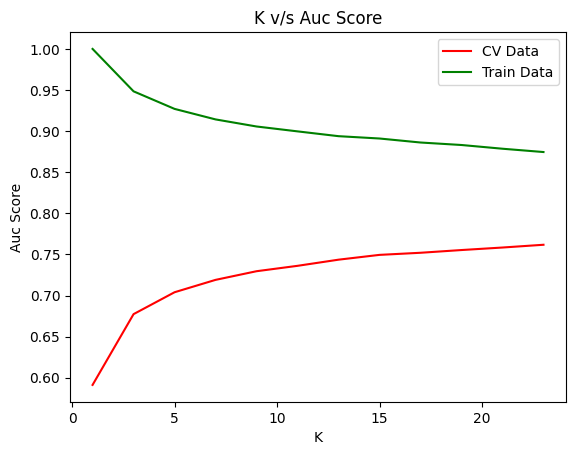

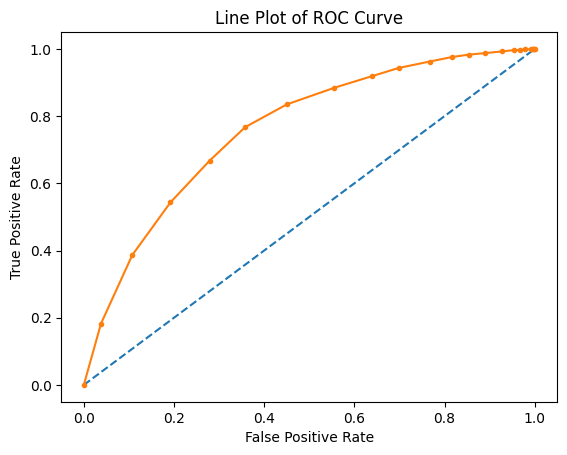

In [68]:
# finding the optimal k using KD Tree for train data
KNN_kdtree(train_tfidfw2v,cv_tfidfw2v,Y_tr2,Y_cv2,n_components=49)

### KNN with simple CV Over the unseen or Test data in AvgW2V 

AUC Score 0.8151893061753351
macro f1 score for data : 0.6485071296416421
micro f1 scoore for data: 0.8718181818181818
hamming loss for data: 0.12818181818181817
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.64      0.26      0.37      1432
           1       0.89      0.98      0.93      8468

    accuracy                           0.87      9900
   macro avg       0.76      0.62      0.65      9900
weighted avg       0.85      0.87      0.85      9900



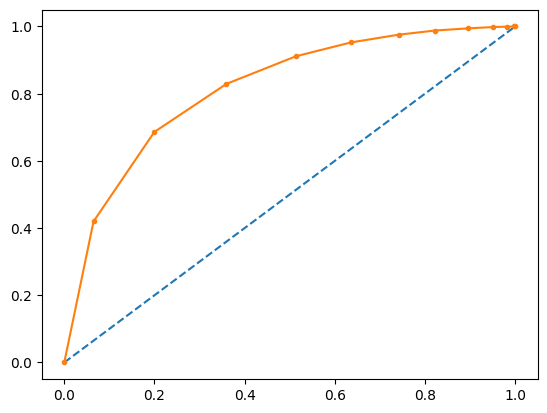

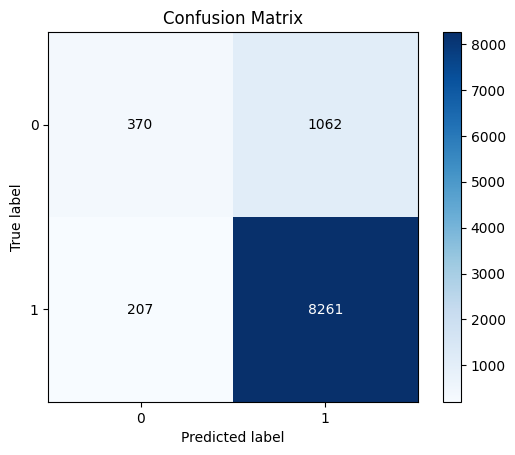

In [69]:
#algorithm as KD Tree, optimal_k= 11 (the K value where curve dosen't changes much)
testing(train_tfidfw2v,Y_tr2,test_tfidfw2v,Y_test2,'kd_tree',optimal_k=11)

For TFIDF Weighted W2V using KD Tree, AUC is 0.81

In [72]:
# ! pip install prettytable 
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Best hyper parameter(K)","Test Auc Score"]

x.add_row(["BoW","Brute",9,77.83])
x.add_row(["BoW","KD-Tree",15,79.60])
x.add_row(["Tf-Idf","Brute",11,78.33])
x.add_row(["Tf-Idf","KD-Tree",7,76.07])
x.add_row(["Avg Word2Vec","Brute",7,83.91])
x.add_row(["Avg Word2Vec","KD-Tree",11,84.00])
x.add_row(["tf idf-Word2vec","Brute",1,51.7])
x.add_row(["tf idf-Word2vec","KD-Tree",11,80.95])
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
printmd('****Final Conclusion:****')
print(x)

****Final Conclusion:****

+-----------------+---------+-------------------------+----------------+
|    Vectorizer   |  Model  | Best hyper parameter(K) | Test Auc Score |
+-----------------+---------+-------------------------+----------------+
|       BoW       |  Brute  |            9            |     77.83      |
|       BoW       | KD-Tree |            15           |      79.6      |
|      Tf-Idf     |  Brute  |            11           |     78.33      |
|      Tf-Idf     | KD-Tree |            7            |     76.07      |
|   Avg Word2Vec  |  Brute  |            7            |     83.91      |
|   Avg Word2Vec  | KD-Tree |            11           |      84.0      |
| tf idf-Word2vec |  Brute  |            1            |      51.7      |
| tf idf-Word2vec | KD-Tree |            11           |     80.95      |
+-----------------+---------+-------------------------+----------------+


##### Conclusion : For KNN model , the most optimal model is Average Word to Vector using KD Tree